In [1]:
import pandas as pd
import sklearn
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/data.csv',encoding='latin-1')
cpi = pd.read_csv('data/cpi.csv')

/tmp/ipykernel_130898/133810174.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/data.csv',encoding='latin-1')


In [3]:
df = df.drop_duplicates(subset=[col for col in df.columns if col not in ['BookingID', 'BCreatedDateAEST', 'BStatusFinal', 'BTicketID' ]])

df['status_priority'] = df['BStatusAfterSubmitted'].apply(lambda x: 0 if x == '33. Approved' else 1)

dedup_cols = [col for col in df.columns if col not in ['BStatusAfterSubmitted', 'BStatusFromDateTimeAEST', 'status_priority']]

df_sorted = df.sort_values(by=dedup_cols + ['status_priority'])

df_deduped = df_sorted.drop_duplicates(subset=dedup_cols, keep='last')

df = df_deduped.drop(columns='status_priority')

In [4]:
# Price adjustment for inflation
df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST']);
df['Quarter'] = df['BCreatedDateAEST'].dt.to_period('Q');
cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');
base_cpi = cpi['CPI'].iloc[-1]

/tmp/ipykernel_130898/1965790900.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');


In [5]:
merged_df = df.merge(cpi, on='Quarter');
#Round to two decimal places to remain consistent with the existing data
merged_df['adjusted_price'] = round(merged_df['PriceIncGSTRaw'] * (base_cpi / merged_df['CPI']), 2)


In [6]:
original_status_column = 'BStatusAfterSubmitted' 
immediately_approved_status = '33. Approved' # The status for the 'Approved' class (1)
explicit_disapproved_status = '16. Requires Changes' # The specific status for the 'Disapproved' class (0)

print("\n--- In merged_df, BEFORE filtering for merged_df_cleaned ---")
print(merged_df['BStatusAfterSubmitted'].value_counts())

merged_df_cleaned = merged_df[merged_df[original_status_column].isin([
    immediately_approved_status,
    explicit_disapproved_status
])].copy()

merged_df_cleaned['IsApproved'] = (merged_df_cleaned[original_status_column] == immediately_approved_status).astype(int)

merged_df_cleaned = merged_df_cleaned.drop(columns=[original_status_column])


target_column = 'IsApproved'

feature_columns = [
    'TaskName',
    'VYear',
    'VMake',
    'VMakeModel',
    'adjusted_price',
    'VMid',
    'BShopRegionClass',
    'VYMM'
]


--- In merged_df, BEFORE filtering for merged_df_cleaned ---
BStatusAfterSubmitted
33. Approved            586953
16. Requires Changes    221889
29. Rejected              5680
Name: count, dtype: int64


In [7]:
#Splitting data (Using whole dataset after removing glitch rows)
X = merged_df_cleaned[feature_columns]
y = merged_df_cleaned[target_column]

train_X, temp_X, train_Y, temp_Y = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

val_X, test_X, val_Y, test_Y = train_test_split(
    temp_X, temp_Y, test_size=0.5, random_state=42, stratify=temp_Y
)

print(f"Train X shape: {train_X.shape}, Train Y shape: {train_Y.shape}")
print(f"Validation X shape: {val_X.shape}, Validation Y shape: {val_Y.shape}")
print(f"Test X shape: {test_X.shape}, Test Y shape: {test_Y.shape}")

Train X shape: (606631, 8), Train Y shape: (606631,)
Validation X shape: (101105, 8), Validation Y shape: (101105,)
Test X shape: (101106, 8), Test Y shape: (101106,)


In [ ]:
categorical_cols = [
    'TaskName',
    'VMake',
    'VMakeModel',
    'VMid',
    'BShopRegionClass',
    'VYMM' 
]

for col in categorical_cols:
    train_X[col] = train_X[col].astype('category').cat.codes
    val_X[col] = val_X[col].astype('category').cat.codes
    test_X[col] = test_X[col].astype('category').cat.codes


In [9]:
model = DecisionTreeClassifier(
    max_depth=5,           
    min_samples_leaf=10,   
    min_samples_split=20,   
    random_state=42,
    class_weight='balanced'
)
model.fit(train_X, train_Y)
#val_predictions = model.predict(Encoded_val_X)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [10]:
# Confidence score at the moment is its confidence in their prediction being correct
# Currently at 1 because its overfitting and is hence over confident 
def eval_classification_performance(model, train_X, y_train, eval_X, y_eval):
    """
    Evaluates a scikit-learn classification model on training and an evaluation dataset,
    displays confusion matrices, prints a classification report, and shows average confidence.

    Args:
        model: Trained scikit-learn classification model.
        train_X: Training features (pandas DataFrame).
        y_train: Training target (pandas Series).
        eval_X: Evaluation features (pandas DataFrame - typically validation or test).
        y_eval: Evaluation target (pandas Series - typically validation or test).
    """
    print("Evaluating model performance...")

    train_pred_labels = model.predict(train_X)

    eval_pred_labels = model.predict(eval_X)

    eval_pred_proba = model.predict_proba(eval_X)

    eval_confidence_in_prediction = np.max(eval_pred_proba, axis=1)

    train_acc = accuracy_score(y_train, train_pred_labels)
    eval_acc = accuracy_score(y_eval, eval_pred_labels) 

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Evaluation Accuracy: {eval_acc:.4f}") 

    print(f"Average Confidence in Predicted Class on Evaluation Set: {np.mean(eval_confidence_in_prediction):.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

    ConfusionMatrixDisplay.from_predictions(y_train, train_pred_labels, normalize='true', ax=axes[0])
    axes[0].set_title(f"Training Set Performance: Accuracy={train_acc:.2f}")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    ConfusionMatrixDisplay.from_predictions(y_eval, eval_pred_labels, normalize='true', ax=axes[1])
    axes[1].set_title(f"Evaluation Set Performance: Accuracy={eval_acc:.2f}") 
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")


    plt.tight_layout()
    plt.show()

    print("\nEvaluation Set Classification Report:") 
    
    print(classification_report(y_eval, eval_pred_labels))



Evaluating model performance...
Training Accuracy: 0.5433
Evaluation Accuracy: 0.4066
Average Confidence in Predicted Class on Evaluation Set: 0.5976


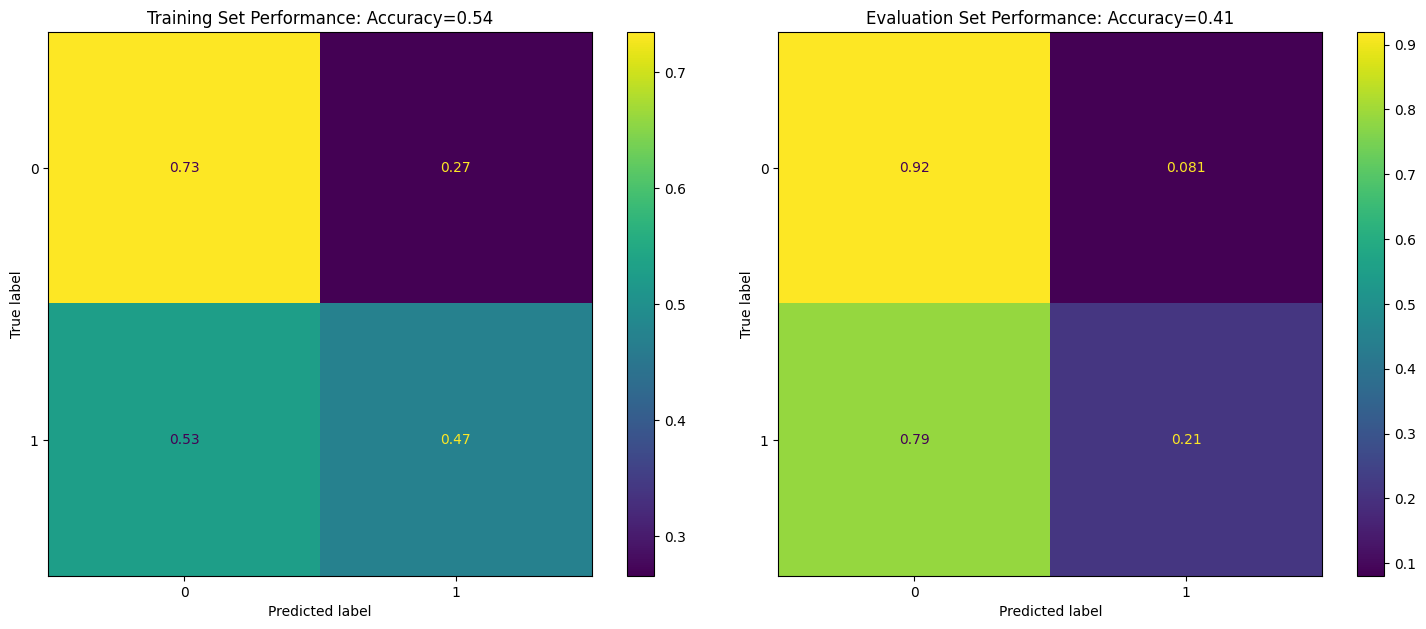


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.92      0.46     27736
           1       0.87      0.21      0.34     73369

    accuracy                           0.41    101105
   macro avg       0.59      0.57      0.40    101105
weighted avg       0.72      0.41      0.37    101105



In [11]:
# For Validation set
eval_classification_performance(model, train_X, train_Y, val_X, val_Y)

Evaluating model performance...
Training Accuracy: 0.5433
Evaluation Accuracy: 0.4054
Average Confidence in Predicted Class on Evaluation Set: 0.5972


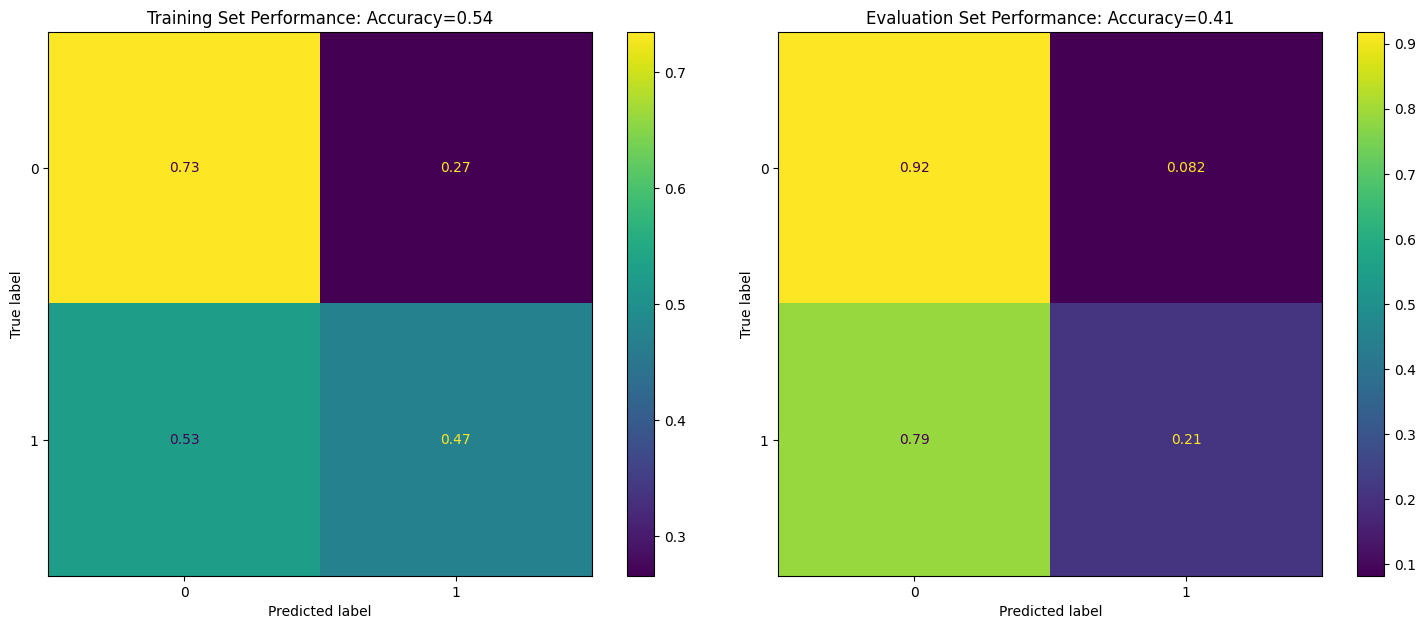


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.92      0.46     27736
           1       0.87      0.21      0.34     73370

    accuracy                           0.41    101106
   macro avg       0.59      0.56      0.40    101106
weighted avg       0.72      0.41      0.37    101106



In [12]:
# For Test set
eval_classification_performance(model, train_X, train_Y, test_X, test_Y)